In [2]:
import sys
import os
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import PDMP_ll as ll
import cPickle as pickle
from IPython.display import display
#from IPython.html.widgets import *
from ipywidgets import widgets
from ipywidgets import interact

trace = pickle.load(open("all_PYY_8hr_trace.p", "rb"))
subj_data = pickle.load(open("all_PYY_8hr_subj.p", "rb"))

# Create formatting tools

In [3]:
import matplotlib as mpl
import matplotlib.cm as cm

subj_labels = []

for i in subj_data:
    subj_labels.append(i[1].split('_'))
    
subj_labels = np.array(subj_labels)
print subj_labels[:,1]

rat_idx = np.unique(trace['theta1'][0,:], return_index=True)[1]
rat_idx = sorted(rat_idx)

def get_indiv(trace, idx):
    num_samples = trace.shape[0]
    
    data_holder = []
    for i in range(0, num_samples):
        data_holder.append(trace[i, idx])
    
    data = np.stack(data_holder)
    return data

## Create metadata holder
metadata = []
groups = []

for i in subj_data:
    x = []
    group = i[0].split('/')[1]
    x.append(group)
    x += i[1].split('_')
    
    metadata.append(x)
    
    if group not in groups:
        groups.append(group)
        
group_id_dict = {}
for i, group_name in enumerate(groups):
    group_id_dict[i] = group_name
    
group_list = np.arange(len(groups))
        
## Create group colourmapper
norm = mpl.colors.Normalize(vmin = 0,
                            vmax = len(groups))

cmap = cm.Paired

group_col = cm.ScalarMappable(norm=norm, cmap=cmap)

## Create dose colourmapper
norm = mpl.colors.PowerNorm(vmin = 0.0,
                            vmax = 300,
                            gamma = 0.1)

cmap = cm.plasma

dose_col = cm.ScalarMappable(norm=norm, cmap=cmap)

## Create amount & rate colourmappers
durs = []
def qty_from_file(filename):
    data = np.loadtxt(filename,delimiter='\t',usecols=(0,1,2,3,4))

    f_lengths = data[:,0]
    g_starts = data[:,1]
    rates = data[:,2]
    p_lengths = data[:,3]
    g_ends = data[:,4]
    
    qty = rates*f_lengths
    dur = sum(f_lengths) + sum(p_lengths)
    durs.append(dur)
    return sum(qty)

## Import amounts
amts_save = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]    
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)
    amts_save.append(amt)
    
amt_norm = mpl.colors.Normalize(vmin = min(amts_save),
                                vmax = max(amts_save))

cmap = cm.plasma

amt_col = cm.ScalarMappable(norm=amt_norm, cmap=cmap)
"""
fig, ax = plt.subplots(1)
ax.scatter(durs, amts_save)
ax.set_ylim((min(amts_save), max(amts_save)))

"""
## Create day/night specific amount colourmapper
day_amts = []
night_amts = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    
    if data[3] == 'L':
        day_amts.append(qty_from_file(path + '/' + filename))
        
    else:
        night_amts.append(qty_from_file(path + '/' + filename))
    
day_norm = mpl.colors.Normalize(vmin = min(day_amts),
                                vmax = max(day_amts))
    
night_norm = mpl.colors.Normalize(vmin = min(night_amts),
                                  vmax = max(night_amts))

cmap = cm.plasma

day_amt_col = cm.ScalarMappable(norm=day_norm, cmap=cmap)
night_amt_col = cm.ScalarMappable(norm=night_norm, cmap=cmap)

## Create day/night line and marker style
period_ms = {'L':'o', 'D':'^'}
period_ls = {'L':'-', 'D':'--'}

## Create drug-dependent dose colourmappers
## PYY
PYY_dict = {1.5:4, 7.5:7, 300.0:10}
PYY_norm = mpl.colors.Normalize(vmin = 0.0,
                                vmax = 10)

PYY_cmap = cm.Greens

PYY_dose_col = cm.ScalarMappable(norm=PYY_norm, cmap=PYY_cmap)

## LiCL
LiCL_norm = mpl.colors.Normalize(vmin = 0.0,
                                 vmax = 64.0)

LiCL_cmap = cm.Reds

LiCL_dose_col = cm.ScalarMappable(norm=LiCL_norm, cmap=LiCL_cmap)

## Lep
Lep_norm = mpl.colors.Normalize(vmin = 0.0,
                                vmax = 2.0)

Lep_cmap = cm.coolwarm

Lep_dose_col = cm.ScalarMappable(norm=Lep_norm, cmap=Lep_cmap)

## Cage ID colourmap
cage_IDs = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    
    cage_IDs.append(float(data[4]))
    
cage_norm = mpl.colors.Normalize(vmin = min(cage_IDs),
                                 vmax = max(cage_IDs))
cage_cmap = cm.tab20

cage_col = cm.ScalarMappable(norm=cage_norm, cmap=cage_cmap)

['300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0'
 '300.0' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5'
 '1.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5'
 '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.5' '1.5' '1.5' '1.5' '1.5'
 '1.5' '1.5' '1.5' '1.5' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '300.0' '300.0' '300.0'
 '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0']


## Pairwise joint posterior plot

This should give a quick overview of how the posterior behaves and where covariance is likely to be.

0
1
2
3
4
5
6
7


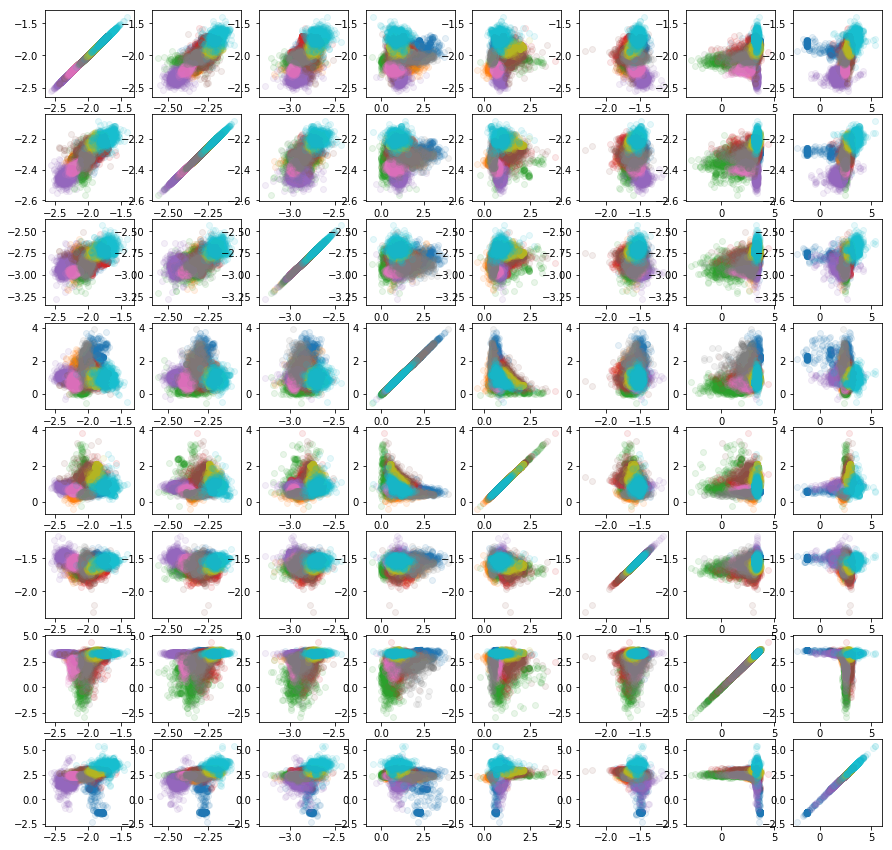

In [4]:
num_vars = 8

fig, axes = plt.subplots(num_vars,num_vars,figsize=(15,15))

thin_param = 1
tune_param = 0
alpha = 0.1

for first_theta in range(0,num_vars):
    print first_theta
    for second_theta in range(0,num_vars):
        #for i in range(0,num_groups):
        for i in group_list:
            #axes[second_theta, first_theta].scatter(np.mean(trace['mu'][tune_param::thin_param,i,first_theta]), np.mean(trace['mu'][tune_param::thin_param,i,second_theta]), alpha=alpha)
            axes[second_theta, first_theta].scatter(trace['mu'][tune_param::thin_param,i,first_theta], trace['mu'][tune_param::thin_param,i,second_theta], alpha=alpha)            
            
#plt.savefig('multi_cov.png')            
plt.show()

## Transition kernel

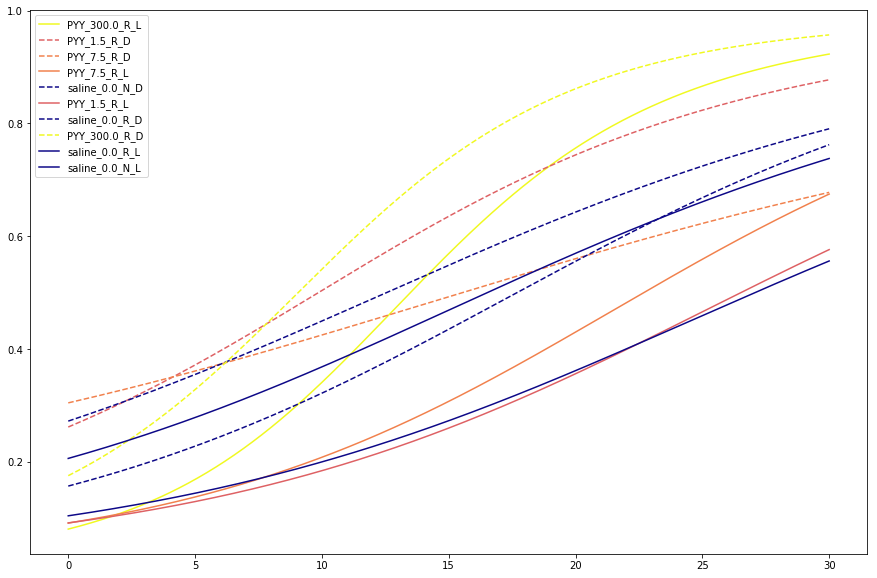

In [5]:
## Get kernel for a joint posterior
def get_Q(xvals, theta5, theta6, percentile=5):
    def sig(x, theta5, theta6):
        eps = 0.01
        return eps + (1. - 2*eps)/(1. + np.exp(-0.1*theta5*(x-20*theta6)))

    sigmoids = []
    for i, t5_val in enumerate(theta5):
        sigmoids.append(sig(xvals, t5_val, theta6[i]))

    sigmoids = np.stack(sigmoids, axis=1)

    sig_min = np.percentile(sigmoids, percentile, axis=1)
    sig_mean = np.mean(sigmoids, axis=1)
    sig_max = np.percentile(sigmoids, 100.-percentile, axis=1)
    
    return sig_min, sig_mean, sig_max

## Setup for plotting
#group_dict = {0:'D_1', 1:'D_2', 2:'L_1', 3:'L_2'}

#group_list = [0, 13, 4, 5, 6, 8]

percentile = 5
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

## Do the plotting
for group_id in group_list:
    
    theta5 = trace['mu'][tune_param::,group_id,3]
    theta6 = trace['mu'][tune_param::,group_id,4]

    xvals = np.linspace(0, 30, 1000)

    sig_min, sig_mean, sig_max = get_Q(xvals, theta5, theta6, percentile)
    
    ## Formatting stuff
    group_data = groups[group_id].split('_')
    dose = float(group_data[1])
    label = group_id_dict[group_id]
    #c = group_col.to_rgba(group_id)
    c = dose_col.to_rgba(dose)
    ls = period_ls[group_data[3]]

    ## Plot using the formatting
    ax.plot(xvals, sig_mean, label=label, c=c, ls=ls)
    #ax.fill_between(xvals, sig_min, sig_max, alpha=0.2, color=c)

ax.legend()
plt.show()

## Pause distribution

In [ ]:
"""## Get distribution for a fixed theta8, theta9
def l_pause(p_lengths, g_ends, theta8, theta9):
    k1 = 0.00055
    t_cs = 2.*np.sqrt(g_ends)/k1
    
    #print p_lengths
    
    #ans_arr = -1*np.ones(len(p_lengths))
    
    #for t in p_lengths:
    
    theta8 = np.power(10., theta8)
    theta9 = np.power(10., theta9)

    g_pausing_1 = 0.25*(k1*p_lengths)**2 - np.sqrt(g_ends)*k1*p_lengths + g_ends

    phi_L_1 = 1./(theta8 + theta9*g_pausing_1)

    psi_L_1 = 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(k1*p_lengths - 2.*np.sqrt(g_ends)))
    psi_L_1 = psi_L_1 - 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(-2.*np.sqrt(g_ends)))
    psi_L_1 = psi_L_1/(k1*np.sqrt(theta8*theta9))

    ll_L_1 = np.log(phi_L_1) - psi_L_1

    
    phi_L_2 = 1./theta8

    psi_L_2 = 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(k1*t_cs - 2.*np.sqrt(g_ends)))
    psi_L_2 = psi_L_2 - 2.*np.arctan(0.5*np.sqrt(theta9/theta8)*(-2.*np.sqrt(g_ends)))
    psi_L_2 = psi_L_2/(k1*np.sqrt(theta8*theta9))

    psi_L_2 = psi_L_2 + (p_lengths-t_cs)/theta8

    ll_L_2 = np.log(phi_L_2) - psi_L_2
        
    ll_L = np.where(p_lengths < t_cs, ll_L_1, ll_L_2)
        
    return ll_L

l_pause_vec = np.vectorize(l_pause)

## Wrap this to generate a posterior estimate
def get_pause(x0, t_vals, theta8, theta9, percentile=33):
    pauses = []
    
    for i, t8_val in enumerate(theta8):
        pauses.append(l_pause(t_vals, x0, t8_val, theta9[i]))

    pauses = np.stack(pauses, axis=1)

    pause_min = np.percentile(pauses, percentile, axis=1)
    pause_mean = np.mean(pauses, axis=1)
    pause_max = np.percentile(pauses, 100.-percentile, axis=1)
    
    return pause_min, pause_mean, pause_max

def plt_pause(x0):
    ## Now do the plotting
    #c_dict = {7:'b', 13:'y', 15:'g', 3:'r'}
    #c_dict = {0:'cyan', 13:'k', 4:'b', 5:'y', 6:'g', 8:'r', 10:'m'}
    c_dict = {0:'b', 7:'r'}
    thin_param = 10
    #x0 = 10
    k1 = 0.00055
    t_cs = 2.*np.sqrt(x0)/k1

    fig = plt.figure(figsize=[15,10])
    ax = fig.add_subplot(111)

    t_vals = np.linspace(0, 20000, 100)

    for group_id in group_list:
        theta8 = trace['mu'][tune_param::thin_param,group_id,6]
        theta9 = trace['mu'][tune_param::thin_param,group_id,7]

        pause_min, pause_mean, pause_max = get_pause(x0, t_vals, theta8, theta9, percentile=5)
        
        ## Formatting stuff
        group_data = groups[group_id].split('_')
        dose = float(group_data[1])
        label = group_id_dict[group_id]
        #c = group_col.to_rgba(group_id)
        #c = dose_col.to_rgba(dose)
        
        if group_data[0] == 'saline' and group_data[2] == 'N':
            c_dose = 'k'
            #continue

        elif group_data[0] == 'saline' and group_data[2] == 'R':
            c_dose = 'b'
            #continue

        elif group_data[0] == 'LiCL':
            c_dose = LiCL_dose_col.to_rgba(dose)
            continue

        elif group_data[0] == 'PYY':
            c_dose = PYY_dose_col.to_rgba(PYY_dict[dose])
            #continue

        elif group_data[0] == 'Lep':
            c_dose = 'y'
            #c_dose = Lep_dose_col.to_rgba(dose)
            continue

        else:
            print "ERROR", data
        
        ls = period_ls[group_data[3]]

        ax.plot(t_vals, np.exp(pause_mean), c=c_dose, ls=ls, label=label)
        #ax.plot(t_vals, pause_min, alpha=0.4, c=c)
        #ax.plot(t_vals, pause_max, alpha=0.4, c=c)
        #ax.fill_between(t_vals, np.exp(pause_min), np.exp(pause_max), alpha=0.1, color=c)

    ax.axvline(t_cs, c='k', ls='--')
    #lbd = np.power(10.,-1.5)
    #exp_pdf = np.log(lbd) - lbd*t_vals
    #ax.plot(t_vals, exp_pdf, c='k')
    #ax.set_ylim([-20,-5])
    
    ax.legend()
    plt.show()

interact(plt_pause, x0=(0,40,1))"""

# Mean long pause time against initial stomach fullness

In [6]:
import scipy

l_pause_vec = np.vectorize(l_pause)

resamples = 10

def integrand(t, x0, theta8, theta9):
    return t * np.exp(l_pause_vec(t, x0, theta8, theta9))

fig, axes = plt.subplots(1, 2, figsize=(15,7.5))
x = np.arange(15)

for group_id in group_list:
    print group_id
    count = 0
    sample_holder = []
    while count < resamples:
        i = np.random.randint(trace['mu'].shape[0]) # randomly sample from posterior
        theta8 = trace['mu'][i,group_id,6]
        theta9 = trace['mu'][i,group_id,7]

        ## Integrate along posterior
        y = []
        for x0 in x:
            y.append(scipy.integrate.quad(integrand, 0, np.inf, args=(x0, theta8, theta9))[0])

        sample_holder.append(y)

        count += 1

    sample_holder = np.array(sample_holder)
    t = np.mean(sample_holder, axis=0)
    std = np.std(sample_holder, axis=0)
    
    ## Formatting stuff
    group_data = groups[group_id].split('_')
    dose = float(group_data[1])
    label = group_id_dict[group_id]

    if group_data[0] == 'saline' and group_data[2] == 'N':
        c_dose = 'k'
        #continue

    elif group_data[0] == 'saline' and group_data[2] == 'R':
        c_dose = 'b'
        #continue

    elif group_data[0] == 'LiCL':
        c_dose = LiCL_dose_col.to_rgba(dose)
        continue

    elif group_data[0] == 'PYY':
        c_dose = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue

    elif group_data[0] == 'Lep':
        c_dose = 'y'
        #c_dose = Lep_dose_col.to_rgba(dose)
        continue

    else:
        print "ERROR", data
        
    ls = period_ls[group_data[3]]

    ## Now do the actual plotting
    if group_data[3] == 'L':
        axes[0].plot(x, t, c=c_dose, label=label, ls=ls)
        axes[0].fill_between(x, t-std, t+std, color=c_dose, alpha=0.3)
    else:
        axes[1].plot(x, t, c=c_dose, label=label, ls=ls)
        axes[1].fill_between(x, t-std, t+std, color=c_dose, alpha=0.3)

## Plot stomach emptying time
k1 = 0.00055
t_cs = 2.*np.sqrt(x)/k1
axes[0].plot(x, t_cs, c='k', ls='--')

## Plot axes etc
axes[0].set_xlabel('Initial stomach fullness')
axes[1].set_xlabel('Initial stomach fullness')
axes[0].set_ylabel('Mean intermeal period')
plt.show()

NameError: name 'l_pause' is not defined

# Detecting clusters from posterior

In [7]:
subj_labels = []

for i in subj_data:
    subj_labels.append(i[1].split('_'))
    
subj_labels = np.array(subj_labels)
print subj_labels[:,1]

['300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0'
 '300.0' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5'
 '1.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5'
 '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.5' '1.5' '1.5' '1.5' '1.5'
 '1.5' '1.5' '1.5' '1.5' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '300.0' '300.0' '300.0'
 '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0']


In [8]:
rat_idx = np.unique(trace['theta1'][0,:], return_index=True)[1]
rat_idx = sorted(rat_idx)

def get_indiv(trace, idx):
    num_samples = trace.shape[0]
    
    data_holder = []
    for i in range(0, num_samples):
        data_holder.append(trace[i, idx])
    
    data = np.stack(data_holder)
    return data

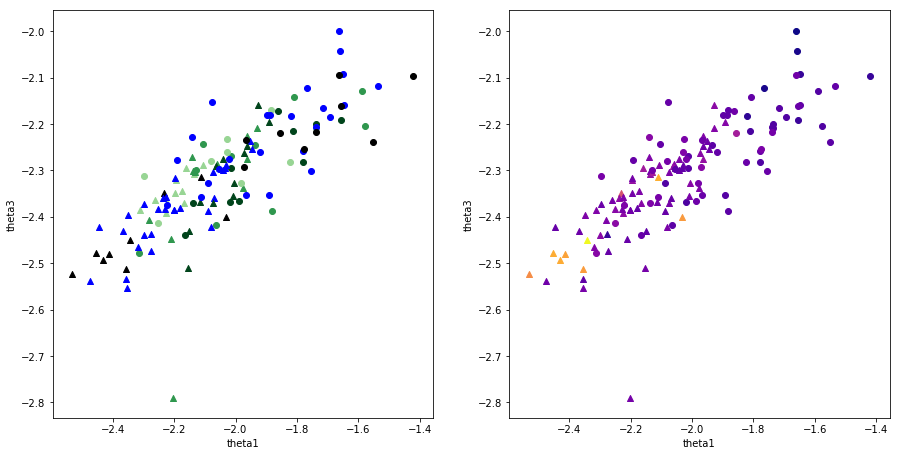

In [11]:
thetas = ['theta1', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9']
var1 = 0
var2 = 1

fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))

x = get_indiv(trace[thetas[var1]], rat_idx)
y = get_indiv(trace[thetas[var2]], rat_idx)

for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]
    dose = float(data[1])
    
    if data[0] == 'saline' and data[2] == 'N':
        c = 'k'
        #continue
        
    elif data[0] == 'saline' and data[2] == 'R':
        c = 'b'
        #continue
        
    elif data[0] == 'LiCL':
        c = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif data[0] == 'Lep':
        c = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
        
    #c = dose_col.to_rgba(dose)
    ms = period_ms[data[3]]
    label = data[0]+data[1]+data[3]
 
    ## Plot with data
    x_ = np.mean(x[:,i])
    y_ = np.mean(y[:,i])

    axes[0].scatter(x_,y_,c=c, marker=ms, label=label)
    
    ## Get feeding data
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)

    ## Formatting stuff
    c = amt_col.to_rgba(amt)
    ms = period_ms[data[3]]
    label = data[0]+data[1]+data[3]

    ## Plot with data
    x_ = np.mean(x[:,i])
    y_ = np.mean(y[:,i])

    axes[1].scatter(x_,y_,c=c, marker=ms, label=label)

"""
for i in range(0,8):
    gp_mean_x = np.mean(trace['mu'][:,i,var1])
    gp_mean_y = np.mean(trace['mu'][:,i,var2])
    
    axes[0].scatter(gp_mean_x, gp_mean_y, c='k')
    axes[1].scatter(gp_mean_x, gp_mean_y, c='k')
"""
#ax.legend()
axes[0].set_xlabel(thetas[var1])
axes[0].set_ylabel(thetas[var2])
axes[1].set_xlabel(thetas[var1])
axes[1].set_ylabel(thetas[var2])
plt.show()

# Predicting feeding amount by theta1/theta3 long axis

r^2 =  0.238517076199
p-value =  1.86684026988e-09


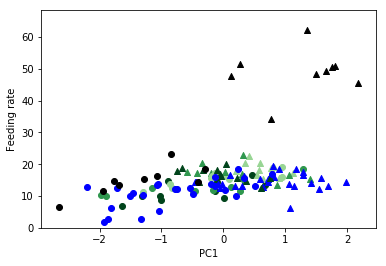

In [10]:
import scipy
from sklearn import decomposition

var1 = 0
var2 = 1

x = get_indiv(trace[thetas[var1]], rat_idx)
y = get_indiv(trace[thetas[var2]], rat_idx)

x_mean = np.mean(x, axis=0)
y_mean = np.mean(y, axis=0)

data = np.stack([x_mean,y_mean]).T

pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(data)

X = pca.transform(data)
X = -1*X[:,0]

Y = []
markers = []
c_arr = []
for i, idx in enumerate(rat_idx):
    ## Get feeding data
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)
    Y.append(amt)
    
    if amt < 0.0001:
        print data
    
    ## Formatting
    ## Marker style
    ms = period_ms[data[3]]
    markers.append(ms)
    
    ## Colour by drug dose
    dose = float(data[1])
    if data[0] == 'saline' and data[2] == 'N':
        c = 'k'
        #continue
        
    elif data[0] == 'saline' and data[2] == 'R':
        c = 'b'
        #continue
        
    elif data[0] == 'LiCL':
        c = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif data[0] == 'Lep':
        c = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
        
    c_arr.append(c)
    
    ## Colour by cage id
    #c_arr.append(cage_col.to_rgba(float(data[4])))F

## Linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X,Y)

print "r^2 = ", r_value*r_value
print "p-value = ", p_value

## Plot
fig, ax = plt.subplots(1)
for i, x in enumerate(X):
    ax.scatter(x, Y[i], marker=markers[i], c=c_arr[i])
ax.set_ylim((0, 1.1*max(Y)))

ax.set_xlabel('PC1')
ax.set_ylabel('Feeding rate')
plt.show()

# Predicting amount eaten from pause parameters

In [ ]:
import scipy
from sklearn import decomposition

var1 = 7
var2 = 6

x = get_indiv(trace[thetas[var1]], rat_idx)
y = get_indiv(trace[thetas[var2]], rat_idx)

x_mean = np.mean(x, axis=0)
y_mean = np.mean(y, axis=0)

data = np.stack([x_mean, y_mean]).T

pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(data)

X = pca.transform(data)
X = X[:,0]

Y = []
markers = []
c_arr = []
for i, idx in enumerate(rat_idx):
    ## Get feeding data
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)
    Y.append(amt)
    
    if amt < 0.0001:
        print data
    
    ## Formatting
    # marker
    ms = period_ms[data[3]]
    markers.append(ms)
    
    # colour by dose
    dose = float(data[1])
    if data[0] == 'saline' and data[2] == 'N':
        c = 'k'
        #continue
        
    elif data[0] == 'saline' and data[2] == 'R':
        c = 'b'
        #continue
        
    elif data[0] == 'LiCL':
        c = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif data[0] == 'Lep':
        c = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
        
    c_arr.append(c)
    
    ## Colour by cage id
    #c_arr.append(cage_col.to_rgba(float(data[4])))

## Linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X,Y)

print "r^2 = ", r_value*r_value
print "p-value = ", p_value

## Plot
fig, axes = plt.subplots(3,1, gridspec_kw = {'height_ratios':[1, 3, 1]})

for i, x in enumerate(X):
    axes[1].scatter(x, Y[i], marker=markers[i], c=c_arr[i])
axes[1].set_ylim((0, 1.1*max(Y)))

axes[1].set_xlabel('PC1')
axes[1].set_ylabel('Feeding rate')

## PC1 KDE
points = {}
grid = np.linspace(min(X), max(X), 1000)
for i, idx in enumerate(rat_idx):
    ## Get feeding data
    data = subj_labels[i]
    category = '_'.join(data[0:4])
    
    try:
        points[category].append(X[i])
    except KeyError:
        points[category] = [X[i]]
        
for key in points.iterkeys():
    ## Get data
    data = key.split('_')
    vals = points[key]
    
    ## Evaluate KDE
    kde = scipy.stats.gaussian_kde(vals)
    kde_vals = kde.evaluate(grid)
    
    ## Set colour
    dose = float(data[1])
    
    if data[0] == 'saline' and data[2] == 'N':
        c = 'k'
        #continue
        
    elif data[0] == 'saline' and data[2] == 'R':
        c = 'b'
        #continue
        
    elif data[0] == 'LiCL':
        c = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif data[0] == 'Lep':
        c = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
    
    ## Plot on grid depending on photoperiod
    if data[-1] == 'L':
        axes[0].plot(grid, kde_vals, c=c)
    else:
        axes[2].plot(grid, kde_vals, c=c)
    
plt.show()

# Colouring by amount eaten

In [ ]:
#% matplotlib inline
thetas = ['theta1', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9']
var1 = 7
var2 = 6

fig, ax = plt.subplots(1, figsize=(10,10))

x = get_indiv(trace[thetas[var1]], rat_idx)
y = get_indiv(trace[thetas[var2]], rat_idx)

for i, idx in enumerate(rat_idx):
    ## Get feeding data
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)

    ## Formatting stuff
    c = amt_col.to_rgba(amt)
    ms = period_ms[data[3]]
    label = data[0]+data[1]+data[3]

    ## Plot with data
    x_ = np.mean(x[:,i])
    y_ = np.mean(y[:,i])

    ax.scatter(x_,y_,c=c, marker=ms, label=label)

for i in range(0,8):
    gp_mean_x = np.mean(trace['mu'][:,i,var1])
    gp_mean_y = np.mean(trace['mu'][:,i,var2])
    
    ax.scatter(gp_mean_x, gp_mean_y, c='k')

#ax.legend()
ax.set_xlabel(thetas[var1])
ax.set_ylabel(thetas[var2])
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

thetas = ['theta1', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9']
var1 = 0
var2 = 6
var3 = 7

x = get_indiv(trace[thetas[var1]], rat_idx)
y = get_indiv(trace[thetas[var2]], rat_idx)
z = get_indiv(trace[thetas[var3]], rat_idx)

for i, idx in enumerate(rat_idx):
    ## Get feeding data
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)

    ## Formatting stuff
    c = amt_col.to_rgba(amt)
    ms = period_ms[data[3]]
    label = data[0]+data[1]+data[3]

    ## Plot with data
    x_ = np.mean(x[:,i])
    y_ = np.mean(y[:,i])
    z_ = np.mean(z[:,i])

    ax.scatter(x_,y_,z_,c=c, marker=ms, label=label)

#for i in range(0,8):
    #gp_mean_x = np.mean(trace['mu'][:,i,var1])
    #gp_mean_y = np.mean(trace['mu'][:,i,var2])
    #ax.scatter(gp_mean_x, gp_mean_y, c='k')

#ax.legend()
ax.set_xlabel(thetas[var1])
ax.set_ylabel(thetas[var2])
ax.set_zlabel(thetas[var3])
plt.show()

# Principal component analysis

In [ ]:
from sklearn import decomposition

data = []

for theta in thetas:
    data.append(np.mean(get_indiv(trace[theta], rat_idx), axis=0))

data = np.array(data).T

pca = decomposition.PCA(n_components=8, whiten=True)
pca.fit(data)

X = pca.transform(data)

fig, axes = plt.subplots(1,2, figsize=(16,8))
for i, idx in enumerate(rat_idx):
    ## Get feeding data
    data = subj_labels[i]
    #print data
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)

    ## Formatting stuff - amount colour
    """
    if data[3] == 'L':
        c_amt = day_amt_col.to_rgba(amt)
    else:
        c_amt = night_amt_col.to_rgba(amt)
    """

    c_amt = amt_col.to_rgba(amt)
    ms = period_ms[data[3]]
    label = data[0]+data[1]+data[3]
    
    ## Formatting stuff - dose colour
    dose = float(data[1])
    #c_dose = dose_col.to_rgba(dose)
    
    if data[0] == 'saline' and data[2] == 'N':
        c_dose = 'k'
        #continue
        
    elif data[0] == 'saline' and data[2] == 'R':
        c_dose = 'b'
        #continue
        
    elif data[0] == 'LiCL':
        c_dose = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif data[0] == 'PYY':
        c_dose = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif data[0] == 'Lep':
        c_dose = 'y'
        #c_dose = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
    
    ms = period_ms[data[3]]
    label = data[0]+data[1]+data[3]

    axes[0].scatter(X[i,0], X[i,1], c=c_dose, marker=ms, label=dose)
    axes[1].scatter(X[i,0], X[i,1], c=c_amt, marker=ms)
    
axes[0].set_xlabel('PC1')
axes[1].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[1].set_ylabel('PC2')

#axes[0].legend()

plt.show()

# Duration and rate of feeding, short pause length

In [ ]:
## Feeding duration
fig, axes = plt.subplots(2,1)
minlim = 0
maxlim = 500

for group_id in group_list:
    
    theta1 = trace['mu'][:,group_id,0]
    theta1_var = np.power(10., theta1)
    
    ## Formatting stuff
    group_data = groups[group_id].split('_')
    dose = float(group_data[1])
    label = group_id_dict[group_id]
    #c = group_col.to_rgba(group_id)
    #c = dose_col.to_rgba(dose)
    
    if group_data[0] == 'saline' and group_data[2] == 'N':
        c_dose = 'k'
        #continue
        
    elif group_data[0] == 'saline' and group_data[2] == 'R':
        c_dose = 'b'
        #continue
        
    elif group_data[0] == 'LiCL':
        c_dose = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif group_data[0] == 'PYY':
        c_dose = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif group_data[0] == 'Lep':
        c_dose = 'y'
        #c_dose = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
    
    ls = period_ls[group_data[3]]
    
    ## Now plot    
    if group_data[3] == 'L':
        axes[0].hist(1./theta1_var, color=c_dose, label=label, alpha=0.7, bins=20)
        
    else:
        axes[1].hist(1./theta1_var, color=c_dose, label=label, alpha=0.7, bins=20)

axes[0].legend()
axes[1].legend()
axes[0].set_title('Mean feeding duration (light)')
#axes[0].set_title('Mean feeding duration (dark)')
axes[0].set_xlim((minlim, maxlim))
axes[1].set_xlim((minlim, maxlim))
plt.show()

In [ ]:
## Feeding rate
fig, axes = plt.subplots(2,1)
minlim = 0
maxlim = 0.01

for group_id in group_list:
    
    theta3 = trace['mu'][:,group_id,1]
    theta3_var = np.power(10., theta3)
    
    ## Formatting stuff
    group_data = groups[group_id].split('_')
    dose = float(group_data[1])
    label = group_id_dict[group_id]
    #c = group_col.to_rgba(group_id)
    #c = dose_col.to_rgba(dose)
    
    if group_data[0] == 'saline' and group_data[2] == 'N':
        c_dose = 'k'
        #continue
        
    elif group_data[0] == 'saline' and group_data[2] == 'R':
        c_dose = 'b'
        #continue
        
    elif group_data[0] == 'LiCL':
        c_dose = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif group_data[0] == 'PYY':
        c_dose = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif group_data[0] == 'Lep':
        c_dose = 'y'
        #c_dose = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
    
    ls = period_ls[group_data[3]]
    
    ## Now plot    
    if group_data[3] == 'L':
        axes[0].hist(theta3_var, color=c_dose, label=label, alpha=0.7, bins=20)
        
    else:
        axes[1].hist(theta3_var, color=c_dose, label=label, alpha=0.7, bins=20)

axes[0].legend()
axes[1].legend()
axes[0].set_title('Mean feeding rate (light)')
#axes[1].set_title('Mean feeding rate (dark)')
axes[0].set_xlim((minlim, maxlim))
axes[1].set_xlim((minlim, maxlim))
plt.show()

In [ ]:
## Feeding rate
fig, axes = plt.subplots(2,1)
minlim = 0
maxlim = 100

for group_id in group_list:
    
    theta7 = trace['mu'][:,group_id,5]
    theta7_var = np.power(10., theta7)
    
    ## Formatting stuff
    group_data = groups[group_id].split('_')
    dose = float(group_data[1])
    label = group_id_dict[group_id]
    #c = group_col.to_rgba(group_id)
    #c = dose_col.to_rgba(dose)
    
    if group_data[0] == 'saline' and group_data[2] == 'N':
        c_dose = 'k'
        #continue
        
    elif group_data[0] == 'saline' and group_data[2] == 'R':
        c_dose = 'b'
        #continue
        
    elif group_data[0] == 'LiCL':
        c_dose = LiCL_dose_col.to_rgba(dose)
        continue
        
    elif group_data[0] == 'PYY':
        c_dose = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    elif group_data[0] == 'Lep':
        c_dose = 'y'
        #c_dose = Lep_dose_col.to_rgba(dose)
        continue
        
    else:
        print "ERROR", data
    
    ls = period_ls[group_data[3]]
    
    ## Now plot    
    if group_data[3] == 'L':
        axes[0].hist(1./theta7_var, color=c_dose, label=label, alpha=0.5, bins=20)
        
    else:
        axes[1].hist(1./theta7_var, color=c_dose, label=label, alpha=0.5, bins=20)

axes[0].legend()
axes[1].legend()
axes[0].set_title('Mean short pause duration (light)')
#axes[1].set_title('Mean feeding rate (dark)')
axes[0].set_xlim((minlim, maxlim))
axes[1].set_xlim((minlim, maxlim))
plt.show()

# Make dataframe of individual posterior means

In [ ]:
theta1_means = np.mean(get_indiv(trace['theta1'], rat_idx), axis=0)
theta3_means = np.mean(get_indiv(trace['theta3'], rat_idx), axis=0)
theta4_means = np.mean(get_indiv(trace['theta4'], rat_idx), axis=0)
theta5_means = np.mean(get_indiv(trace['theta5'], rat_idx), axis=0)
theta6_means = np.mean(get_indiv(trace['theta6'], rat_idx), axis=0)
theta7_means = np.mean(get_indiv(trace['theta7'], rat_idx), axis=0)
theta8_means = np.mean(get_indiv(trace['theta8'], rat_idx), axis=0)
theta9_means = np.mean(get_indiv(trace['theta9'], rat_idx), axis=0)

print theta1_means

In [ ]:
import pandas as pd

thetas = np.stack([theta1_means, theta3_means, theta4_means,
                   theta5_means, theta6_means, theta7_means,
                   theta8_means, theta9_means], axis=1)

data = np.concatenate([thetas, subj_labels], axis=1)

columns = ['theta1', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9',
           'drug', 'dose', 'fast', 'period', 'cage_id', 'filename']

df = pd.DataFrame(data, columns=columns)

df['dose'] = df['dose'].astype('float')

df['theta1'] = df['theta1'].astype('float')
df['theta3'] = df['theta3'].astype('float')
df['theta4'] = df['theta4'].astype('float')
df['theta5'] = df['theta5'].astype('float')
df['theta6'] = df['theta6'].astype('float')
df['theta7'] = df['theta7'].astype('float')
df['theta8'] = df['theta8'].astype('float')
df['theta9'] = df['theta9'].astype('float')

In [ ]:
fig, axes = plt.subplots(1,2)

var1 = 'theta6'
var2 = 'theta7'

for i in df['cage_id'].unique():
    rat_data = df[df['cage_id'] == i].sort_values('dose')
    
    if len(rat_data) < 4:
        continue
    
    x = np.array(rat_data[var1])
    y = np.array(rat_data[var2])
    
    axes[0].plot(x, y, 'o-')
    
    axes[1].scatter(x[0], y[0], c='k')
    axes[1].scatter(x[-3], y[-3], c='b')
    axes[1].scatter(x[-2], y[-2], c='g')
    axes[1].scatter(x[-1], y[-1], c='r')
    
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())
    
plt.show()

# Forward sampling test

The code that follows is largely from the notebook 'forward sampling', with some minor modifications to deal with the fact that we now have a covariance matrix for each group

In [ ]:
import fwd_sample as fs
reload(fs)
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import pymc3 as pm
import scipy

print np.version.version
print scipy.__version__

In [ ]:
trace_size = trace['mu'].shape[0]

theta = trace['mu'][0,0,:]
x0 = 0.0
tmax = 60*60*12
x, amount_eaten, num_events, bout_lengths, short_lengths, long_lengths, events = fs.sample(tmax, theta, x0)

plt.plot(x)
plt.show()

In [ ]:
def cov_from_chol(num_vars, chol):
    cov = np.zeros((num_vars, num_vars))
    
    for i in range(0, num_vars):        
        chol_factor = chol[i*(i+1)/2:(i+1)*(i+2)/2]
        
        row_to_add = np.zeros(num_vars)
        row_to_add[0:len(chol_factor)] = chol[i*(i+1)/2:(i+1)*(i+2)/2]
        
        cov[i,:] = row_to_add
        
    cov = np.dot(cov, cov.T)
        
    #cov = cov + np.tril(cov).T
    
    #print cov
    
    return cov

def sample_group(group_id, sample_num):
    mu = trace['mu'][sample_num,group_id,:]
    
    chol = trace['chol_cov'+str(group_id)][sample_num,:] # modified to include different cov matrices
    cov = cov_from_chol(8, chol)
    
    return mu, cov

sample_group(0,0)

mu, cov = sample_group(0, 100)

for i in range(0, trace_size):    
    ans = np.random.multivariate_normal(mu, cov)
    
    plt.scatter(ans[0], ans[1])
    
plt.show()

In [ ]:
num_animals = 10
num_samples = 10
group_id = 3

durations = [4,4,4,4]

x0 = 0
tmax = 60*60*durations[group_id]

all_qtys = []

for i in range(0, num_samples):
    sample_idx = np.random.randint(0, trace_size)
    
    mu, cov = sample_group(group_id, sample_idx)
    
    thetas = np.random.multivariate_normal(mu, cov, size=num_animals)
    
    qty_holder = np.zeros(num_animals)
    
    for j, theta_set in enumerate(thetas):
        #x, amount_eaten, num_events, bout_lengths, short_lengths, long_lengths, events = fs.sample(tmax, theta_set, x0)
        qty_holder[j] = fs.sample(tmax, theta_set, x0)[1]
        
    all_qtys.append(qty_holder)
    
qtys = np.stack(all_qtys, axis=1)

mean_qty = np.mean(qtys, axis=0)
std_qty = np.std(qtys, axis=0)

idx = np.arange(0, num_samples)

fig, ax = plt.subplots(1)

ax.errorbar(mean_qty, idx, xerr=std_qty, fmt='o')

plt.show()

In [ ]:
import os

#root_data_dir = 'all_data/'
#group_paths = os.listdir(root_data_dir)

group_paths = ['PYY_300.0_R_L', 'PYY_7.5_R_L', 'PYY_1.5_R_L', 'saline_0.0_R_L']

data_dir = 'all_data/' + group_paths[group_id]

print data_dir

def qty_from_file(filename):
    data = np.loadtxt(filename,delimiter='\t',usecols=(0,1,2,3,4))

    f_lengths = data[:,0]
    g_starts = data[:,1]
    rates = data[:,2]
    p_lengths = data[:,3]
    g_ends = data[:,4]
    
    qty = rates*f_lengths
    return sum(qty)
    
    #qty = len(f_lengths)
    #return qty  

true_qty = []

for filename in os.listdir(data_dir):
    if filename [-3:] != 'CSV':
        continue
        
    else:
        new_data = qty_from_file(data_dir+'/'+filename)
        true_qty.append(new_data)
        
true_mean = np.mean(true_qty)
true_std = np.std(true_qty)

In [ ]:
fig, ax = plt.subplots(1)

ax.errorbar(mean_qty, idx, xerr=std_qty, fmt='o')

ax.axvline(true_mean, c='k')
ax.axvline(true_mean-true_std, c='k', ls='--')
ax.axvline(true_mean+true_std, c='k', ls='--')

fig.suptitle(data_dir)

fig.savefig(data_dir+".png")

plt.show()

In the 4 hour time window our estimates seem pretty reasonable - this is good news

## Amount eaten and parameter movement

Now it'll be interesting to see if the movement in parameter space can be related naturally to the amount each animal has eaten. This should be doable by creating a dataframe of posterior means and feeding amounts by combining the posterior with the raw data.

In [ ]:
def get_feeding_amount(x):
    path = x[0]
    filename = x[1]
    
    return qty_from_file(path+'/'+filename)

pre_df = []

for i in subj_data:
    amt = get_feeding_amount(i)
    row = i[1].split('_')
    newline = [row[0], float(row[1]), int(row[4]), amt, row[3], row[2]]
    pre_df.append(newline)
    
columns = ['drug', 'dose', 'cage_id', 'amount', 'period', 'fasting']
results_df = pd.DataFrame(pre_df, columns=columns)

print results_df

In [ ]:
import seaborn as sns

filtered_df = results_df[results_df['period'] == 'D']
filtered_df = filtered_df[filtered_df['fasting'] == 'R']
sns.factorplot(x='dose', y='amount', hue='cage_id', data=filtered_df)
#sns.factorplot(x='dose', y='amount', hue='cage_id', data=filtered_df)

print filtered_df.groupby('dose')['amount'].mean()

plt.show()

So it seems that the general trend is for 1.5 to cause a small increase in feeding, 7.5 to return it to normal, and 300 to cause a decrease. Two rats bucked this trend and showed a decrease in feeding at 1.5, so it'd be worth checking if they have unusual parameter behaviour. It's interesting that this is mapped well in parameter space too. First need to get feeding data into the theta dataframe and define a colourmap for plotting.

In [ ]:
def feeding_from_row(row):
    path = [row['drug'], str(row['dose']), row['fast'], row['period']]

    path = '_'.join(path)
    
    filename = path + '_' + row['cage_id'] + '_' + row['filename']
    
    return qty_from_file('all_data'+'/'+path+'/'+filename)
   
df['amount'] = df.apply(feeding_from_row, axis=1)

In [ ]:
ref_dose = 0.0
ref_df = df[df['dose'] == ref_dose]
amounts = ref_df['amount']

norm = mpl.colors.Normalize(vmin = min(amounts),
                            vmax = max(amounts))

cmap = cm.viridis

feed_col = cm.ScalarMappable(norm=norm, cmap=cmap)

def make_par_plot(var1, var2, save=False):
    fig, axes = plt.subplots(1,2)
    
    for i in df['cage_id'].unique():
        rat_data = df[df['cage_id'] == i].sort_values('dose')

        #print rat_data[['dose', 'amount']]

        if len(rat_data) < 4:
            continue

        x = np.array(rat_data[var1])
        y = np.array(rat_data[var2])

        z = np.array(rat_data['amount'])
        c = feed_col.to_rgba(z[0])

        axes[0].plot(x, y, marker='o', c=c)

        axes[1].scatter(rat_data[rat_data['dose'] == 0.0][var1], rat_data[rat_data['dose'] == 0.0][var2], c='k')
        axes[1].scatter(rat_data[rat_data['dose'] == 1.5][var1], rat_data[rat_data['dose'] == 1.5][var2], c='b')
        axes[1].scatter(rat_data[rat_data['dose'] == 7.5][var1], rat_data[rat_data['dose'] == 7.5][var2], c='g')
        axes[1].scatter(rat_data[rat_data['dose'] == 300.0][var1], rat_data[rat_data['dose'] == 300.0][var2], c='r')

    axes[1].set_xlim(axes[0].get_xlim())
    axes[1].set_ylim(axes[0].get_ylim())
    
    if save == True:
        fig.savefig(var1+var2+'.png')

make_par_plot(var1, var2, save=True)
    
plt.show()

In [ ]:
thetas = ['theta1', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9']

for i, var1 in enumerate(thetas):
    print var1
    for var2 in thetas[0:i]:
        make_par_plot(var1, var2, save=True)

Let's look at the delta between 0 and 1.5 to see if this provides any more insight.

In [ ]:
def make_par_plot_delta(var1, var2, save=False):
    fig, axes = plt.subplots(1,2)
    x = []
    y = []
    c_vals = []
    
    for i in df['cage_id'].unique():
        rat_data = df[df['cage_id'] == i].sort_values('dose')

        #print rat_data[['dose', 'amount']]

        try:
            z1  =  np.array(rat_data[rat_data['dose'] == 0.0]['amount'])[0]
            z2  =  np.array(rat_data[rat_data['dose'] == 1.5]['amount'])[0]
            c_val = z1 - z2
            c_vals.append(c_val)
            
            x_ = np.array(rat_data[var1])
            y_ = np.array(rat_data[var2])

            x.append(x_)
            y.append(y_)

            axes[1].scatter(rat_data[rat_data['dose'] == 0.0][var1], rat_data[rat_data['dose'] == 0.0][var2], c='k')
            axes[1].scatter(rat_data[rat_data['dose'] == 1.5][var1], rat_data[rat_data['dose'] == 1.5][var2], c='b')
            axes[1].scatter(rat_data[rat_data['dose'] == 7.5][var1], rat_data[rat_data['dose'] == 7.5][var2], c='g')
            axes[1].scatter(rat_data[rat_data['dose'] == 300.0][var1], rat_data[rat_data['dose'] == 300.0][var2], c='r')
            
        except:
            continue
    
    norm = mpl.colors.Normalize(vmin = min(c_vals),
                                vmax = max(c_vals))

    cmap = cm.coolwarm

    feed_col = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    c = feed_col.to_rgba(c_vals)
    
    for i in range(0, len(x)):
        axes[0].plot(x[i], y[i], marker='o', c=c[i])

    axes[1].set_xlim(axes[0].get_xlim())
    axes[1].set_ylim(axes[0].get_ylim())
    
    if save == True:
        fig.savefig('results/'+'delta_'+var1+var2+'.png')

thetas = ['theta1', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9']

make_par_plot_delta(var1, var2, save=False)

for i, var1 in enumerate(thetas):
    print var1
    for var2 in thetas[0:i]:
        make_par_plot_delta(var1, var2, save=True)